In [1]:
# !! You have to restart session after executing this cell !!
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

     |████████████████████████████████| 11.3 MB 5.4 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.5 which is incompatible.


     |████████████████████████████████| 109 kB 4.0 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [1]:
import os
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
# Write a path to load model from
root = '/gdrive/My Drive/CS492_Project/LSTM_Model'

In [31]:
#importing packages
import pandas as pd
import numpy as np
import datetime as dt
import pandas_datareader as pdr
import seaborn as sns
import matplotlib.pyplot as plt
import bs4 as bs
import requests
from IPython.display import clear_output
from scipy.stats import mstats
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import RandomizedSearchCV, validation_curve, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pickle
import os
sns.set()

#Obtain list of S&100 companies from wikipedia
resp = requests.get("https://en.wikipedia.org/wiki/S%26P_100")
convert_soup = bs.BeautifulSoup(resp.text, 'lxml')
table = convert_soup.find('table',{'class':'wikitable sortable'})

tickers = []

for rows in table.findAll('tr')[1:]:
    ticker = rows.findAll('td')[0].text.strip()
    tickers.append(ticker)

all_data = pd.DataFrame()
test_data = pd.DataFrame()
no_data = []

#Extract data from Yahoo Finance
for i in tickers:
    try:
        print(i)
        test_data = pdr.get_data_yahoo(i, start = dt.datetime(2019,1,1), end = dt.datetime(2020,12,31))
        test_data['symbol'] = i
        all_data = all_data.append(test_data)
        clear_output(wait = True)
    except:
        no_data.append(i)

    clear_output(wait = True)

XOM


In [32]:
# Simple Moving Average
all_data['SMA_5'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.rolling(window = 5).mean())
all_data['SMA_15'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.rolling(window = 15).mean())
all_data['SMA_ratio'] = all_data['SMA_15'] / all_data['SMA_5']

In [33]:
# Simple Moving Average of Volume
all_data['SMA5_Volume'] = all_data.groupby('symbol')['Volume'].transform(lambda x: x.rolling(window = 5).mean())
all_data['SMA15_Volume'] = all_data.groupby('symbol')['Volume'].transform(lambda x: x.rolling(window = 15).mean())
all_data['SMA_Volume_Ratio'] = all_data['SMA5_Volume']/all_data['SMA15_Volume']

In [34]:
def Wilder(data, periods):
    start = np.where(~np.isnan(data))[0][0] #Check if nans present in beginning
    Wilder = np.array([np.nan]*len(data))
    Wilder[start+periods-1] = data[start:(start+periods)].mean() #Simple Moving Average
    for i in range(start+periods,len(data)):
        Wilder[i] = (Wilder[i-1]*(periods-1) + data[i])/periods #Wilder Smoothing
    return(Wilder)

In [35]:
# Average True Return

all_data['prev_close'] = all_data.groupby('symbol')['Close'].shift(1)
all_data['TR'] = np.maximum((all_data['High'] - all_data['Low']), 
                     np.maximum(abs(all_data['High'] - all_data['prev_close']), 
                     abs(all_data['prev_close'] - all_data['Low'])))
for i in all_data['symbol'].unique():
    TR_data = all_data[all_data.symbol == i].copy()
    all_data.loc[all_data.symbol==i,'ATR_5'] = Wilder(TR_data['TR'], 5)
    all_data.loc[all_data.symbol==i,'ATR_15'] = Wilder(TR_data['TR'], 15)

all_data['ATR_Ratio'] = all_data['ATR_5'] / all_data['ATR_15']

In [36]:
# Average Directional Movement

all_data['prev_high'] = all_data.groupby('symbol')['High'].shift(1)
all_data['prev_low'] = all_data.groupby('symbol')['Low'].shift(1)

all_data['+DM'] = np.where(~np.isnan(all_data.prev_high),
                           np.where((all_data['High'] > all_data['prev_high']) & 
         (((all_data['High'] - all_data['prev_high']) > (all_data['prev_low'] - all_data['Low']))), 
                                                                  all_data['High'] - all_data['prev_high'], 
                                                                  0),np.nan)

all_data['-DM'] = np.where(~np.isnan(all_data.prev_low),
                           np.where((all_data['prev_low'] > all_data['Low']) & 
         (((all_data['prev_low'] - all_data['Low']) > (all_data['High'] - all_data['prev_high']))), 
                                    all_data['prev_low'] - all_data['Low'], 
                                    0),np.nan)

for i in all_data['symbol'].unique():
    ADX_data = all_data[all_data.symbol == i].copy()
    all_data.loc[all_data.symbol==i,'+DM_5'] = Wilder(ADX_data['+DM'], 5)
    all_data.loc[all_data.symbol==i,'-DM_5'] = Wilder(ADX_data['-DM'], 5)
    all_data.loc[all_data.symbol==i,'+DM_15'] = Wilder(ADX_data['+DM'], 15)
    all_data.loc[all_data.symbol==i,'-DM_15'] = Wilder(ADX_data['-DM'], 15)

all_data['+DI_5'] = (all_data['+DM_5']/all_data['ATR_5'])*100
all_data['-DI_5'] = (all_data['-DM_5']/all_data['ATR_5'])*100
all_data['+DI_15'] = (all_data['+DM_15']/all_data['ATR_15'])*100
all_data['-DI_15'] = (all_data['-DM_15']/all_data['ATR_15'])*100

all_data['DX_5'] = (np.round(abs(all_data['+DI_5'] - all_data['-DI_5'])/(all_data['+DI_5'] + all_data['-DI_5']) * 100))

all_data['DX_15'] = (np.round(abs(all_data['+DI_15'] - all_data['-DI_15'])/(all_data['+DI_15'] + all_data['-DI_15']) * 100))

for i in all_data['symbol'].unique():
    ADX_data = all_data[all_data.symbol == i].copy()
    all_data.loc[all_data.symbol==i,'ADX_5'] = Wilder(ADX_data['DX_5'], 5)
    all_data.loc[all_data.symbol==i,'ADX_15'] = Wilder(ADX_data['DX_15'], 15)

In [37]:
# Stochastic Oscillator

all_data['Lowest_5D'] = all_data.groupby('symbol')['Low'].transform(lambda x: x.rolling(window = 5).min())
all_data['High_5D'] = all_data.groupby('symbol')['High'].transform(lambda x: x.rolling(window = 5).max())
all_data['Lowest_15D'] = all_data.groupby('symbol')['Low'].transform(lambda x: x.rolling(window = 15).min())
all_data['High_15D'] = all_data.groupby('symbol')['High'].transform(lambda x: x.rolling(window = 15).max())

all_data['Stochastic_5'] = ((all_data['Close'] - all_data['Lowest_5D'])/(all_data['High_5D'] - all_data['Lowest_5D']))*100
all_data['Stochastic_15'] = ((all_data['Close'] - all_data['Lowest_15D'])/(all_data['High_15D'] - all_data['Lowest_15D']))*100

all_data['Stochastic_%D_5'] = all_data['Stochastic_5'].rolling(window = 5).mean()
all_data['Stochastic_%D_15'] = all_data['Stochastic_5'].rolling(window = 15).mean()

all_data['Stochastic_Ratio'] = all_data['Stochastic_%D_5']/all_data['Stochastic_%D_15']

In [38]:
# Relative Strength Index

all_data['Diff'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.diff())
all_data['Up'] = all_data['Diff']
all_data.loc[(all_data['Up']<0), 'Up'] = 0

all_data['Down'] = all_data['Diff']
all_data.loc[(all_data['Down']>0), 'Down'] = 0 
all_data['Down'] = abs(all_data['Down'])

all_data['avg_5up'] = all_data.groupby('symbol')['Up'].transform(lambda x: x.rolling(window=5).mean())
all_data['avg_5down'] = all_data.groupby('symbol')['Down'].transform(lambda x: x.rolling(window=5).mean())

all_data['avg_15up'] = all_data.groupby('symbol')['Up'].transform(lambda x: x.rolling(window=15).mean())
all_data['avg_15down'] = all_data.groupby('symbol')['Down'].transform(lambda x: x.rolling(window=15).mean())

all_data['RS_5'] = all_data['avg_5up'] / all_data['avg_5down']
all_data['RS_15'] = all_data['avg_15up'] / all_data['avg_15down']

all_data['RSI_5'] = 100 - (100/(1+all_data['RS_5']))
all_data['RSI_15'] = 100 - (100/(1+all_data['RS_15']))

all_data['RSI_ratio'] = all_data['RSI_5']/all_data['RSI_15']

In [39]:
# Moving Average Convergence Divergence
all_data['5Ewm'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.ewm(span=5, adjust=False).mean())
all_data['15Ewm'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.ewm(span=15, adjust=False).mean())
all_data['MACD'] = all_data['15Ewm'] - all_data['5Ewm']

In [40]:
all_data['15MA'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.rolling(window=15).mean())
all_data['SD'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.rolling(window=15).std())
all_data['upperband'] = all_data['15MA'] + 2*all_data['SD']
all_data['lowerband'] = all_data['15MA'] - 2*all_data['SD']

In [41]:
all_data['RC'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.pct_change(periods = 15)) 

In [42]:
# Target Direction and Moving Percent
all_data['Close_Shifted'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.shift(-6))
all_data['Close_Yester'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.shift(1))
all_data['Moving_Percent'] = ((all_data['Close_Yester'] - all_data['Close'])/(all_data['Close_Yester']) * 100)
all_data['Target'] = ((all_data['Close_Shifted'] - all_data['Open'])/(all_data['Open']) * 100)
all_data['Target_Direction'] = np.where(all_data['Target']>0,1,0)
all_data = all_data.dropna().copy()

In [43]:
def dataset_generator (dataset, x_label, y_label, targets, window_len):
  for i in range (window_len, len(dataset) - window_len):
    if not targets == None:
      x = dataset.loc[i-window_len:i-1, targets]
    else:
       x = dataset.iloc[i]
    x_label.append(x)

    if not y_label == None:
      y = dataset.loc[i, ['Target_Direction']]
      y_label.append(y)

In [44]:
def pred_tomorrow (date, pred_check, predicted_value):
  # date = pd.to_datetime(date)
  index_list = []
  for i,x in enumerate(pred_check):
    if x.name == date:
      index_list.append(i)

  pred_for_tomorrow = pd.DataFrame({'Date':[],
                                    'company':[],
                                    'prediction':[]})

  if (len(index_list)):
      pred_for_tomorrow = pred_for_tomorrow.append(pd.DataFrame({'Date':[pred_check[i].name for i in index_list],
                                                                  'company':[pred_check[i]['symbol'] for i in index_list],
                                                                  'prediction':[predicted_value[i] for i in index_list]}), ignore_index = True)
  else: 
    return None
  top_10_pred = pred_for_tomorrow.sort_values(by = ['prediction'], ascending = False).head(10)
  for selected_company in top_10_pred['company']:
      actual = all_data[all_data.symbol == selected_company].loc[date,'Target_Direction']
      pct_change = all_data[all_data.symbol == selected_company].loc[date,'Target']
      top_10_pred.loc[top_10_pred.company == selected_company,'actual'] = actual
      top_10_pred.loc[top_10_pred.company == selected_company,'pct_change'] = pct_change
  return top_10_pred.sum()['pct_change']/10

In [45]:
def test_lstm (Test_X, Test_Y, pred_check, time_index, config_num, window_len):
  model = pickle.load(open(f'{root}/config_{config_num}_{window_len}', 'rb'))
  predicted_value= model.predict(Test_X)

  cum_return_graph = []
  cum_return = []
  checker = 0

  for j in range(7):
    cum_return.append(1/7)
  for time in time_index:
    change_rate = pred_tomorrow (time, pred_check, predicted_value)
    if (change_rate == None):
      continue
    cum_return[checker % 7] *= (1 + change_rate/100)
    cum_return_graph.append ((sum(cum_return), time))
    checker += 1
  print("config:", list(vc_dict.keys())[config_num], " %return:", sum(cum_return)*100)
  return cum_return_graph

In [46]:
total_target_var = ['SMA_ratio','ATR_5','ATR_15','ATR_Ratio',
                       'ADX_5','ADX_15','SMA_Volume_Ratio','Stochastic_5','Stochastic_15','Stochastic_Ratio',
                      'RSI_5','RSI_15','RSI_ratio','MACD']

In [47]:
vc_dict = {
    "Baseline": [], 
    "SMA_Price": [0], 
    "ATR": [1, 2, 3], 
    "ADX": [4, 5], 
    "SMA_Volume": [6], 
    "Stochastic": [7, 8, 9], 
    "RSI": [10, 11, 12], 
    "MACD": [13],
    "All_feature": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]}

In [48]:
"""
  Test models and save cummlative return graph in cum_return_graph_dict

  config_num:
  0 -> baseline
  1 -> SMA_Price 
  2 -> ATR 
  3 -> ADX 
  4 -> SMA_Volume 
  5 -> Stochastic 
  6 -> RSI 
  7 -> MACD
  8 -> All feature
"""

from sklearn.preprocessing import MinMaxScaler
import copy

# Save cummulative return for each config_num
cum_return_graph_dict = {}

window_length = 8

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))

for config_num, vc in enumerate(vc_dict.values()):
  Target_variables = []
  test_data = all_data.copy()
  for ti in vc:
    Target_variables.append(total_target_var[ti])
  Target_variables.append('Moving_Percent')
  for variable in Target_variables:
    test_data.loc[:,variable] = mstats.winsorize(test_data.loc[:,variable], limits = [0.1,0.1])
  for variable in Target_variables:
    test_data[[variable]] = min_max_scaler.fit_transform(test_data[[variable]])
  test_data = test_data['2020-01-01':]
  test_data.index = pd.to_datetime(test_data.index)
  time_index = test_data[test_data['symbol'] == 'AAPL'].index

  Test_X = []
  Test_Y = []
  pred_check = []
  for i in tickers:
    test_data_sym = test_data[test_data['symbol'] == i]
    dataset_generator (test_data_sym.reset_index(), Test_X, Test_Y, Target_variables, window_length)
    dataset_generator (test_data_sym, pred_check, None, None, window_length)
  Test_X = np.array(Test_X).astype(float)
  Test_Y = np.array(Test_Y).astype(float)
  cum_return_graph = test_lstm (Test_X, Test_Y, pred_check, time_index, config_num, window_length)
  cum_return_graph_copy = copy.deepcopy(cum_return_graph)
  cum_return_graph_dict[f'config_{config_num}_{window_length}'] = cum_return_graph_copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.


config: Baseline  %return: 121.39174062159101


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_sin

config: SMA_Price  %return: 121.8390988994886


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.


config: ATR  %return: 127.11658087685382


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.


config: ADX  %return: 130.24537643671354


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_sin

config: SMA_Volume  %return: 123.28649168849314


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.


config: Stochastic  %return: 128.22389206887442


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.


config: RSI  %return: 121.823664435227


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_sin

config: MACD  %return: 125.64428167901896


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_sin

config: All_feature  %return: 126.44374452834354


In [49]:
def test_lstm_ensemble (Test_set, Test_Y, pred_check, time_index, window_len):
  model_list = []
  pred_list = []
  pred_val_list = []
  for i in range(1, 8):
    model = pickle.load(open(f'{root}/config_{i}_{window_len}', 'rb'))
    model_list.append (model)
  for i in range(7):
    pred = model_list[i].predict(Test_set[i])
    pred_list.append(pred)
  for i in range (len (pred_list [0])):
    pred_val = 0
    for j in range (7):
      pred_val += pred_list[j][i].item()
    pred_val_list.append (pred_val/7)

  checker = 0
  cum_return_graph = []
  cum_return = []
  for j in range(7):
    cum_return.append(1/7)
  for time in time_index:
    change_rate = pred_tomorrow (time, pred_check, pred_val_list)
    if (change_rate == None):
      continue
    cum_return[checker % 7] *= (1 + change_rate/100)
    cum_return_graph.append ((sum(cum_return), time))
    checker += 1
  print("config: LSTM ensemble", " %return:", sum(cum_return)*100)
  return cum_return_graph

In [50]:
vc_dict_ensemble = { 
    "SMA_Price": [0], 
    "ATR": [1, 2, 3], 
    "ADX": [4, 5], 
    "SMA_Volume": [6], 
    "Stochastic": [7, 8, 9], 
    "RSI": [10, 11, 12], 
    "MACD": [13]}

In [51]:
# Test ensemble model using pretrained models

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))

window_length = 8
Test_set = []
pred_check_ensemble = None

for config_num, vc in enumerate(vc_dict_ensemble.values()):
  Target_variables = []
  test_data = all_data.copy()
  for ti in vc:
    Target_variables.append(total_target_var[ti])
  Target_variables.append('Moving_Percent')
  for variable in Target_variables:
    test_data.loc[:,variable] = mstats.winsorize(test_data.loc[:,variable], limits = [0.1,0.1])
  for variable in Target_variables:
    test_data[[variable]] = min_max_scaler.fit_transform(test_data[[variable]])
  test_data.index = pd.to_datetime(test_data.index)
  time_index = test_data[test_data['symbol'] == 'AAPL'].index
  
  Test_X = []
  Test_Y = []
  if pred_check == None:
    pred_check = []
  for i in tickers:
    test_data_sym = test_data[test_data['symbol'] == i]
    dataset_generator (test_data_sym.reset_index(), Test_X, Test_Y, Target_variables, window_length)
    if (pred_check == None):
      dataset_generator (test_data_sym, pred_check, None, None, window_length)
  Test_X = np.array(Test_X).astype(float)
  Test_Y = np.array(Test_Y).astype(float)
  Test_set.append(Test_X)
cum_return_graph = test_lstm_ensemble (Test_set, Test_Y, pred_check, time_index, window_length)
cum_return_graph_copy = copy.deepcopy(cum_return_graph)
cum_return_graph_dict[f'config_9_{window_length}'] = cum_return_graph_copy

config: LSTM ensemble  %return: 111.11133684718189


In [53]:
def std_dev(data):
    # Get number of observations
    n = len(data)
    # Calculate mean
    mean = sum(data) / n
    # Calculate deviations from the mean
    deviations = sum([(x - mean)**2 for x in data])
    # Calculate Variance & Standard Deviation
    variance = deviations / (n - 1)
    s = variance**(1/2)
    return s

# Sharpe Ratio From Scratch
def sharpe_ratio(data, risk_free_rate=0.0):
    # Calculate Average Daily Return
    mean_daily_return = sum(data) / len(data)
    # Calculate Standard Deviation
    s = std_dev(data)
    # Calculate Daily Sharpe Ratio
    daily_sharpe_ratio = (mean_daily_return - risk_free_rate) / s
    # Annualize Daily Sharpe Ratio
    sharpe_ratio = 252**(1/2) * daily_sharpe_ratio
    
    return sharpe_ratio

In [54]:
"""
  Print result of all 9 models

  config_num:
  0 -> baseline
  1 -> SMA_Price 
  2 -> ATR 
  3 -> ADX 
  4 -> SMA_Volume 
  5 -> Stochastic 
  6 -> RSI 
  7 -> MACD
  8 -> All feature
  9 -> Ensemble model
"""

for i in range(10):
  temp_list = []
  trend = list(map(lambda x:x[0], cum_return_graph_dict[f'config_{i}_{8}']))
  prev = 1
  for j in range(len(trend)-1):
    temp_list.append(trend[j+1] - prev)
    prev = trend[j+1]
  if i != 9:
    config_name = list(vc_dict.keys())[i]
  else:
    config_name = "Ensemble"
  print(
      "config:", config_name,
      "%return:", cum_return_graph_dict[f'config_{i}_{8}'][-1][0] * 100,
      "sharpe_ratio:", sharpe_ratio(temp_list))

config: Baseline %return: 121.39174062159101 sharpe_ratio: 1.7894818141104203
config: SMA_Price %return: 121.8390988994886 sharpe_ratio: 1.7668675930866213
config: ATR %return: 127.11658087685382 sharpe_ratio: 2.117301663536687
config: ADX %return: 130.24537643671354 sharpe_ratio: 2.502446549761918
config: SMA_Volume %return: 123.28649168849314 sharpe_ratio: 2.064562776243223
config: Stochastic %return: 128.22389206887442 sharpe_ratio: 2.2676673384215023
config: RSI %return: 121.823664435227 sharpe_ratio: 1.866987653131239
config: MACD %return: 125.64428167901896 sharpe_ratio: 1.985936038374164
config: All_feature %return: 126.44374452834354 sharpe_ratio: 2.350035576854996
config: Ensemble %return: 111.11133684718189 sharpe_ratio: 1.0686338381844624


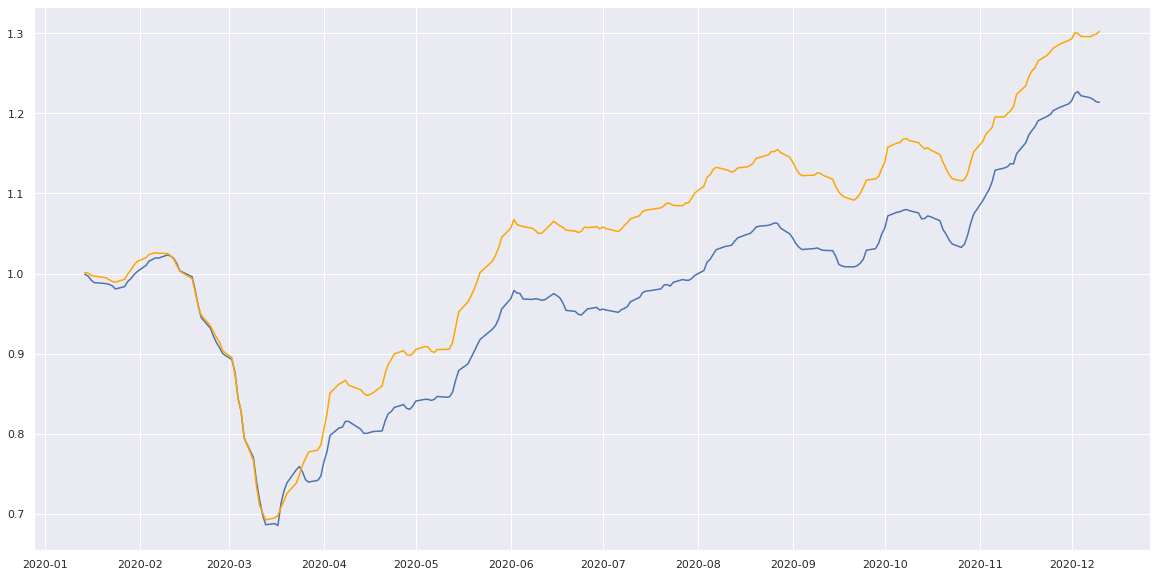

In [56]:
# Print graph
config_num_1 = 0
config_num_2 = 3

plt.figure(figsize=(20,10))
plt.plot(list(map(lambda x:x[1], cum_return_graph_dict[f'config_{config_num_1}_{8}'])), list(map(lambda x:x[0], cum_return_graph_dict[f'config_{config_num_1}_{8}'])))
plt.plot(list(map(lambda x:x[1], cum_return_graph_dict[f'config_{config_num_2}_{8}'])), list(map(lambda x:x[0], cum_return_graph_dict[f'config_{config_num_2}_{8}'])), c='orange')
plt.show()